### import

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interp
from sklearn import svm
from sklearn.datasets import load_iris, make_classification, make_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    mean_squared_error,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    StratifiedKFold,
    cross_val_predict,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

os.chdir("/data3/wuli/proj/wuli/cfRNA/brain/01_bulk/figure")

In [ ]:
path = "/data3/wuli/proj/wuli/cfRNA/brain/01_bulk/data/cfRNA_train.csv"
train = pd.read_csv(path, encoding="utf-8")

X = train.iloc[:, 1:-1]
y = train.iloc[:, -1]
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

(267, 107)


In [ ]:
path = "/data3/wuli/proj/wuli/cfRNA/brain/01_bulk/data/cfRNA_vaild.csv"
valid = pd.read_csv(path, encoding="utf-8")

X_valid = valid.iloc[:, 1:-1]
y_valid = valid.iloc[:, -1]
print(X_valid.shape)

(70, 107)


### 网格搜索+交叉验证

In [ ]:
classifier = RandomForestClassifier(random_state=42)

param_grid = {
    "n_estimators": np.arange(50, 201, 50).tolist(), 
    "max_depth": np.arange(5, 21, 5).tolist(),
    "min_samples_split": np.arange(2, 11, 2).tolist(),
    "min_samples_leaf": np.arange(2, 11, 2).tolist()
    # "bootstrap": [True, False],
    # "criterion": ["gini", "entropy"], 
}

n_splits = 10
cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=0, error_score='raise')

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}


In [ ]:
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the best model found: {accuracy:.8f}")

cv_results = grid_search.cv_results_
mean_cv_accuracy = cv_results["mean_test_score"][grid_search.best_index_]
print(f"Mean cross-validated accuracy of the best model: {mean_cv_accuracy:.8f}")

Accuracy of the best model found: 0.77777778
Mean cross-validated accuracy of the best model: 0.75584416


### 最佳参数训练

In [ ]:
best_classifier = grid_search.best_estimator_

best_classifier.fit(X_train, y_train)

cv_scores = cross_val_score(best_classifier, X_train, y_train, cv=10)

print(f"10-fold cross-validation scores: {cv_scores}")
print(f"Average accuracy: {cv_scores.mean():.8f}")
print(f"Standard deviation: {cv_scores.std():.8f}")

train_accuracy = accuracy_score(y_train, best_classifier.predict(X_train))
print(f"Accuracy train: {train_accuracy:.8f}")
test_accuracy = accuracy_score(y_test, best_classifier.predict(X_test))
print(f"Accuracy test: {test_accuracy:.8f}")
valid_accuracy = accuracy_score(y_valid, best_classifier.predict(X_valid))
print(f"Accuracy valid: {valid_accuracy:.8f}")

10-fold cross-validation scores: [0.72727273 0.77272727 0.72727273 0.66666667 0.80952381 0.57142857
 0.80952381 0.71428571 0.71428571 0.85714286]
Average accuracy: 0.73701299
Standard deviation: 0.07733818
Accuracy train: 0.96244131
Accuracy test: 0.77777778
Accuracy valid: 0.58571429


### RFECV

In [ ]:
clf = grid_search.best_estimator_

n_splits = 10
# cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
rfecv = RFECV(
    estimator=clf, step=1, cv=cv, n_jobs=-1, verbose=0,
    importance_getter='auto', scoring="accuracy", # roc_auc accuracy
    min_features_to_select=1,)

rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)
print("Cross-validation scores for each number of selected features:", rfecv.grid_scores_)
print("Ranking of features:", rfecv.ranking_)

Optimal number of features : 47
Cross-validation scores for each number of selected features: [[0.48148148 0.48148148 0.59259259 ... 0.57692308 0.57692308 0.46153846]
 [0.7037037  0.62962963 0.55555556 ... 0.65384615 0.76923077 0.42307692]
 [0.7037037  0.62962963 0.59259259 ... 0.57692308 0.69230769 0.5       ]
 ...
 [0.7037037  0.66666667 0.7037037  ... 0.65384615 0.76923077 0.53846154]
 [0.74074074 0.7037037  0.7037037  ... 0.65384615 0.73076923 0.61538462]
 [0.7037037  0.7037037  0.74074074 ... 0.57692308 0.80769231 0.5       ]]
Ranking of features: [47  1  1  1  1  1 17  5 48 32  1 45 51  1 14 31 24 11  1  4 46  1  1  1
  1  1  1  1  1  1  6  2  1 38  7  1 15  1 40 12  3  1 39  1  1  1 37 49
 36 58 28  1  1 10 53  1  1  1  1 34  1 55  1 26  1 27  1 44  1 20 54 22
 52 33  1 13 57  8 25 16 30 42 61  1 21 56 23 19 60 35 43  1  1  1  1  1
  1  1 50  1 41  1 59 18  9  1 29]


/data2/wuli/software/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
mean_scores = np.mean(rfecv.grid_scores_, axis=1)
idx = np.where(rfecv.ranking_ == 1)[0]
importances = mean_scores[idx]
print(importances)

genes = train.iloc[:, 1:-1].columns[rfecv.ranking_ == 1]
print(genes)

feature_importance_df = pd.DataFrame({
    'Feature': genes, 
    'Importance': importances
})
feature_importance_df.to_csv('feature_importances.csv', index=False)

[0.63276353 0.63618234 0.62136752 0.6511396  0.63618234 0.64316239
 0.63618234 0.66253561 0.6548433  0.65826211 0.65512821 0.66638177
 0.66994302 0.65868946 0.66965812 0.66994302 0.66609687 0.71111111
 0.68133903 0.68874644 0.68490028 0.69245014 0.69230769 0.70754986
 0.69985755 0.70726496 0.69245014 0.68504274 0.6962963  0.7039886
 0.69985755 0.70740741 0.7037037  0.7037037  0.69245014 0.69230769
 0.68490028 0.70712251 0.6997151  0.6960114  0.69615385 0.69230769
 0.68518519 0.69957265 0.69230769 0.6957265  0.7       ]
Index(['ATP6', 'ATP8', 'COX2', 'COX3', 'CYTB', 'IGLV6.57', 'MTATP6P1',
       'MTRNR2L2', 'ND2', 'ND3', 'ND4', 'ND4L', 'ND5', 'ND6', 'NPEPPSP1',
       'PWP2', 'RNA5.8SN3', 'RNF182', 'SAP25', 'SMIM11', 'BPIFA3', 'C1orf147',
       'C1QTNF2', 'CAV3', 'DLX3', 'DUX4L26', 'FAM83E', 'FOXA2', 'GDF6',
       'GPR17', 'HOXC12', 'HTR1A', 'IRS4', 'KRT8P32', 'LACTBL1', 'NR2E3',
       'OR4M1', 'PRB2', 'PRB4', 'PRPS1L1', 'SH3GL2', 'SIX6', 'SKOR2',
       'SLC22A6', 'SPATA46', 'TFAP2

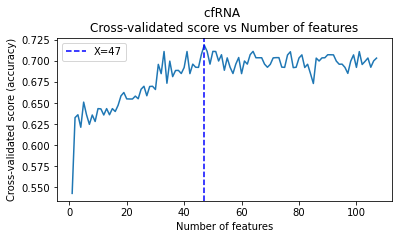

In [ ]:
plt.figure(figsize=(6, 3))
plt.plot(range(1, len(rfecv.grid_scores_) + 1), np.mean(rfecv.grid_scores_, axis=1))
plt.xlabel('Number of features')
plt.ylabel('Cross-validated score (accuracy)')
plt.title('cfRNA \nCross-validated score vs Number of features')
plt.axvline(x=47, linestyle="--", color="blue", label="X=47")
plt.legend()
plt.savefig('cross_val_score_vs_features_cfRNA.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

### 特征选取后训练

In [175]:
gene = train.iloc[:, 1:-1].columns
selected_genes = gene[rfecv.ranking_ == 1]
selected_genes

Index(['ATP6', 'ATP8', 'COX2', 'COX3', 'CYTB', 'IGLV6.57', 'MTATP6P1',
       'MTRNR2L2', 'ND2', 'ND3', 'ND4', 'ND4L', 'ND5', 'ND6', 'NPEPPSP1',
       'PWP2', 'RNA5.8SN3', 'RNF182', 'SAP25', 'SMIM11', 'BPIFA3', 'C1orf147',
       'C1QTNF2', 'CAV3', 'DLX3', 'DUX4L26', 'FAM83E', 'FOXA2', 'GDF6',
       'GPR17', 'HOXC12', 'HTR1A', 'IRS4', 'KRT8P32', 'LACTBL1', 'NR2E3',
       'OR4M1', 'PRB2', 'PRB4', 'PRPS1L1', 'SH3GL2', 'SIX6', 'SKOR2',
       'SLC22A6', 'SPATA46', 'TFAP2D', 'TRIM75'],
      dtype='object')

In [176]:
# genes = ['ACSL1', 'ANPEP', 'APLNR', 'ARL1', 'BCL2', 'BCL6', 'CCT5', 'CREB5',
#        'CYTH1', 'EZR', 'FLOT2', 'GCA', 'GGA2', 'HSPA8', 'IKZF1', 'LAMTOR4',
#        'LBH', 'MNDA', 'MRPS23', 'MTATP6P1', 'MTRNR2L12', 'NEAT1', 'PTPN6',
#        'RAB11FIP4', 'RBM47', 'RPL3P4', 'RPL6P27', 'RPS17', 'RUNX2', 'SNX30',
#        'STIP1', 'TSPYL1', 'YBEY', 'ZBTB18', "group"]

genes = list(selected_genes)
genes.append("group")

In [ ]:
path = "/data3/wuli/proj/wuli/cfRNA/brain/01_bulk/data/cfRNA_train.csv"
train = pd.read_csv(path, encoding="utf-8")
train = train.iloc[:, 1:][genes]

X = train.iloc[:, :-1] 
y = train.iloc[:, -1] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
print(X_train.shape)

        ATP6      ATP8      COX2      COX3       CYTB  IGLV6.57  MTATP6P1  \
0   9.154084  6.771835  9.085818  8.925299   9.936742  8.555905  7.137064   
1  10.283037  8.203854  9.935053  9.389243  10.714722  6.184738  7.655069   
2  10.263784  7.905914  9.606922  8.969391  10.263784  6.215557  7.498111   

   MTRNR2L2        ND2       ND3  ...      PRB4   PRPS1L1    SH3GL2      SIX6  \
0  6.107082   8.646117  7.156289  ...  8.395287  8.397717  7.916866  8.564547   
1  6.749795  10.613234  8.394773  ...  5.596908  5.820403  5.820403  5.596908   
2  6.426042  10.370744  7.916177  ...  5.921781  5.596908  5.784737  5.596908   

      SKOR2   SLC22A6   SPATA46    TFAP2D    TRIM75  group  
0  8.421790  9.125435  9.017230  9.091758  8.199592      1  
1  5.596908  5.596908  5.596908  5.596908  5.596908      1  
2  5.596908  5.784737  5.784737  5.596908  5.596908      1  

[3 rows x 48 columns]
(213, 47)


In [ ]:
path = "/data3/wuli/proj/wuli/cfRNA/brain/01_bulk/data/cfRNA_vaild.csv"
valid =pd.read_csv(path, encoding="utf-8")
valid = valid.iloc[:, 1:][genes]

X_valid = valid.iloc[:, :-1]
y_valid = valid.iloc[:, -1]
print(X_valid.shape)

(70, 47)


### 最终结果

#### 随机森林

Accuracy Train: 0.9356807511737089
Accuracy Test: 0.7851851851851852
Accuracy Valid: 0.57


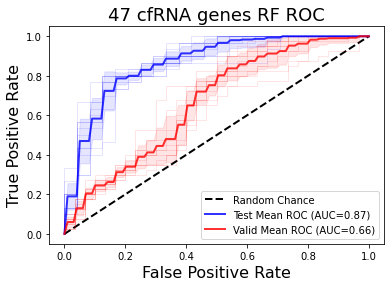

In [ ]:
classifier = grid_search.best_estimator_

n_splits = 10
cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

tprs_train = []
aucs_train = []
accuracy_train = 0

tprs_valid = []
aucs_valid = []
accuracy_valid = 0

tprs_test = []
aucs_test = []
accuracy_test = 0

mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="black", label="Random Chance", alpha=1)

for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    classifier.fit(X_train.iloc[train], y_train.iloc[train])

    ### Train dataset -------------------------------------
    curr_score = classifier.score(X_train, y_train)
    accuracy_train = accuracy_train + curr_score

    y_score_train = classifier.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_score_train)
    viz_train = roc_auc_score(y_train, y_score_train)

    interp_tpr_train = np.interp(mean_fpr, fpr_train, tpr_train)
    interp_tpr_train[0] = 0.0

    tprs_train.append(interp_tpr_train)
    aucs_train.append(viz_train)

    # ax.plot(fpr_train, tpr_train, lw=1, alpha=0.1, color="b")

    ### Validation dataset -------------------------------------
    curr_score = classifier.score(X_valid, y_valid)
    accuracy_valid = accuracy_valid + curr_score

    y_score_valid = classifier.predict_proba(X_valid)[:, 1]
    fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_score_valid)
    viz_valid = roc_auc_score(y_valid, y_score_valid)

    interp_tpr_valid = np.interp(mean_fpr, fpr_valid, tpr_valid)
    interp_tpr_valid[0] = 0.0

    tprs_valid.append(interp_tpr_valid)
    aucs_valid.append(viz_valid)

    ax.plot(fpr_valid, tpr_valid, lw=1, alpha=0.1, color="r")

    ### Test dataset -------------------------------------
    curr_score = classifier.score(X_test, y_test)
    accuracy_test = accuracy_test + curr_score

    y_score_test = classifier.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_score_test)
    viz_test = roc_auc_score(y_test, y_score_test)

    interp_tpr_test = np.interp(mean_fpr, fpr_test, tpr_test)
    interp_tpr_test[0] = 0.0

    tprs_test.append(interp_tpr_test)
    aucs_test.append(viz_test)

    ax.plot(fpr_test, tpr_test, lw=1, alpha=0.1, color="b")

accuracy_train = accuracy_train / n_splits
accuracy_valid = accuracy_valid / n_splits
accuracy_test = accuracy_test / n_splits
print("Accuracy Train:", accuracy_train)
print("Accuracy Test:", accuracy_test)
print("Accuracy Valid:", accuracy_valid)

mean_tpr_train = np.mean(tprs_train, axis=0)
mean_tpr_valid = np.mean(tprs_valid, axis=0)
mean_tpr_test = np.mean(tprs_test, axis=0)

mean_auc_train = auc(mean_fpr, mean_tpr_train)
mean_auc_valid = auc(mean_fpr, mean_tpr_valid)
mean_auc_test = auc(mean_fpr, mean_tpr_test)

std_tpr_train = np.std(tprs_train, axis=0)
tprs_upper_train = np.minimum(mean_tpr_train + std_tpr_train, 1)
tprs_lower_train = np.maximum(mean_tpr_train - std_tpr_train, 0)
# ax.fill_between(mean_fpr, tprs_lower_train, tprs_upper_train, color="g", alpha=0.1)

std_tpr_valid = np.std(tprs_valid, axis=0)
tprs_upper_valid = np.minimum(mean_tpr_valid + std_tpr_valid, 1)
tprs_lower_valid = np.maximum(mean_tpr_valid - std_tpr_valid, 0)
ax.fill_between(mean_fpr, tprs_lower_valid, tprs_upper_valid, color="r", alpha=0.1)

std_tpr_test = np.std(tprs_test, axis=0)
tprs_upper_test = np.minimum(mean_tpr_test + std_tpr_test, 1)
tprs_lower_test = np.maximum(mean_tpr_test - std_tpr_test, 0)
ax.fill_between(mean_fpr, tprs_lower_test, tprs_upper_test, color="b", alpha=0.1)

ax.plot(mean_fpr, mean_tpr_test, color="b", lw=2, alpha=0.8, label=r"Test Mean ROC (AUC=%0.2f)" % (mean_auc_test),)
ax.plot(mean_fpr, mean_tpr_valid, color="r", lw=2, alpha=0.8, label=r"Valid Mean ROC (AUC=%0.2f)" % (mean_auc_valid),)

ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel("False Positive Rate", fontsize=16)
ax.set_ylabel("True Positive Rate", fontsize=16)
ax.set_title("47 cfRNA genes RF ROC", fontsize=18)
ax.legend(loc="lower right")
plt.savefig('cross_val_score_vs_features_cfRNA_RF.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

#### SVM

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 
X_valid_scaled = scaler.transform(X_valid)

classifier = svm.SVC(probability=True)

param_grid = {
    "C": [0.1, 1, 10, 100],
    "gamma": ["scale", "auto", 0.1, 0.01, 0.001],
    # 'kernel': ['linear', 'rbf', 'poly']
    "kernel": ["linear"]
}

n_splits = 10
cv = KFold(n_splits=n_splits, shuffle=True, random_state=42) # Mean cross-validated accuracy of the best model: 0.69956710
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)
print("Best parameters found: ", grid_search.best_params_)

best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the best model found: {accuracy:.8f}")

cv_results = grid_search.cv_results_
mean_cv_accuracy = cv_results["mean_test_score"][grid_search.best_index_]
print(f"Mean cross-validated accuracy of the best model: {mean_cv_accuracy:.8f}")

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best parameters found:  {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy of the best model found: 0.70370370
Mean cross-validated accuracy of the best model: 0.70432900


Accuracy Train: 0.7812206572769953
Accuracy Test: 0.7481481481481481
Accuracy Valid: 0.5957142857142855


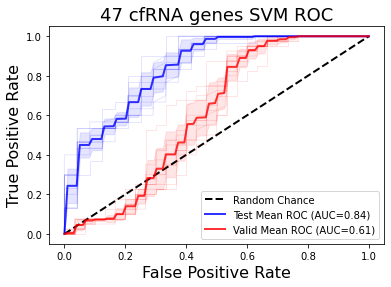

In [ ]:
classifier = grid_search.best_estimator_

n_splits = 10
cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

tprs_train = []
aucs_train = []
accuracy_train = 0

tprs_valid = []
aucs_valid = []
accuracy_valid = 0

tprs_test = []
aucs_test = []
accuracy_test = 0

mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="black", label="Random Chance", alpha=1)

for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    classifier.fit(X_train.iloc[train], y_train.iloc[train])

    ### Train dataset -------------------------------------
    curr_score = classifier.score(X_train, y_train)
    accuracy_train = accuracy_train + curr_score

    y_score_train = classifier.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_score_train)
    viz_train = roc_auc_score(y_train, y_score_train)

    interp_tpr_train = np.interp(mean_fpr, fpr_train, tpr_train)
    interp_tpr_train[0] = 0.0

    tprs_train.append(interp_tpr_train)
    aucs_train.append(viz_train)

    ### Validation dataset -------------------------------------
    curr_score = classifier.score(X_valid, y_valid)
    accuracy_valid = accuracy_valid + curr_score

    y_score_valid = classifier.predict_proba(X_valid)[:, 1]
    fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_score_valid)
    viz_valid = roc_auc_score(y_valid, y_score_valid)

    interp_tpr_valid = np.interp(mean_fpr, fpr_valid, tpr_valid)
    interp_tpr_valid[0] = 0.0

    tprs_valid.append(interp_tpr_valid)
    aucs_valid.append(viz_valid)

    ax.plot(fpr_valid, tpr_valid, lw=1, alpha=0.1, color="r")

    ### Test dataset -------------------------------------
    curr_score = classifier.score(X_test, y_test)
    accuracy_test = accuracy_test + curr_score

    y_score_test = classifier.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_score_test)
    viz_test = roc_auc_score(y_test, y_score_test)

    interp_tpr_test = np.interp(mean_fpr, fpr_test, tpr_test)
    interp_tpr_test[0] = 0.0

    tprs_test.append(interp_tpr_test)
    aucs_test.append(viz_test)

    ax.plot(fpr_test, tpr_test, lw=1, alpha=0.1, color="b")

accuracy_train = accuracy_train / n_splits
accuracy_valid = accuracy_valid / n_splits
accuracy_test = accuracy_test / n_splits
print("Accuracy Train:", accuracy_train)
print("Accuracy Test:", accuracy_test)
print("Accuracy Valid:", accuracy_valid)

mean_tpr_train = np.mean(tprs_train, axis=0)
mean_tpr_valid = np.mean(tprs_valid, axis=0)
mean_tpr_test = np.mean(tprs_test, axis=0)

mean_auc_train = auc(mean_fpr, mean_tpr_train)
mean_auc_valid = auc(mean_fpr, mean_tpr_valid)
mean_auc_test = auc(mean_fpr, mean_tpr_test)

std_tpr_train = np.std(tprs_train, axis=0)
tprs_upper_train = np.minimum(mean_tpr_train + std_tpr_train, 1)
tprs_lower_train = np.maximum(mean_tpr_train - std_tpr_train, 0)

std_tpr_valid = np.std(tprs_valid, axis=0)
tprs_upper_valid = np.minimum(mean_tpr_valid + std_tpr_valid, 1)
tprs_lower_valid = np.maximum(mean_tpr_valid - std_tpr_valid, 0)
ax.fill_between(mean_fpr, tprs_lower_valid, tprs_upper_valid, color="r", alpha=0.1)

std_tpr_test = np.std(tprs_test, axis=0)
tprs_upper_test = np.minimum(mean_tpr_test + std_tpr_test, 1)
tprs_lower_test = np.maximum(mean_tpr_test - std_tpr_test, 0)
ax.fill_between(mean_fpr, tprs_lower_test, tprs_upper_test, color="b", alpha=0.1)

ax.plot(mean_fpr, mean_tpr_test, color="b", lw=2, alpha=0.8, label=r"Test Mean ROC (AUC=%0.2f)" % (mean_auc_test),)
ax.plot(mean_fpr, mean_tpr_valid, color="r", lw=2, alpha=0.8, label=r"Valid Mean ROC (AUC=%0.2f)" % (mean_auc_valid),)

ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel("False Positive Rate", fontsize=16)
ax.set_ylabel("True Positive Rate", fontsize=16)
ax.set_title("47 cfRNA genes SVM ROC", fontsize=18)
ax.legend(loc="lower right")
plt.savefig('cross_val_score_vs_features_cfRNA_SVM.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

#### 逻辑回归分类

In [ ]:
classifier = LogisticRegression(solver='liblinear', penalty='l1', max_iter=1000) # 选择 'liblinear' 或 'sag' 作为求解器

param_grid = {"C": [0.1, 1.0, 10.0]}

n_splits = 10
cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=0, error_score='raise')
grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'C': 1.0}


Accuracy Train: 0.7793427230046948
Accuracy Test: 0.6796296296296297
Accuracy Valid: 0.5971428571428572


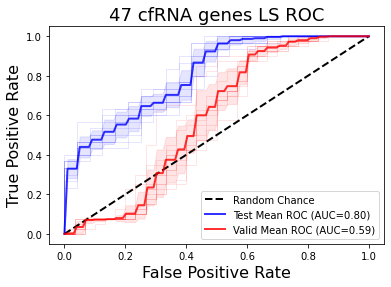

In [ ]:
classifier = grid_search.best_estimator_

n_splits = 10
cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

tprs_train = []
aucs_train = []
accuracy_train = 0

tprs_valid = []
aucs_valid = []
accuracy_valid = 0

tprs_test = []
aucs_test = []
accuracy_test = 0

mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="black", label="Random Chance", alpha=1)

for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    classifier.fit(X_train.iloc[train], y_train.iloc[train])

    ### Train dataset -------------------------------------
    curr_score = classifier.score(X_train, y_train)
    accuracy_train = accuracy_train + curr_score

    y_score_train = classifier.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_score_train)
    viz_train = roc_auc_score(y_train, y_score_train)

    interp_tpr_train = np.interp(mean_fpr, fpr_train, tpr_train)
    interp_tpr_train[0] = 0.0

    tprs_train.append(interp_tpr_train)
    aucs_train.append(viz_train)

    ### Validation dataset -------------------------------------
    curr_score = classifier.score(X_valid, y_valid)
    accuracy_valid = accuracy_valid + curr_score

    y_score_valid = classifier.predict_proba(X_valid)[:, 1]
    fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_score_valid)
    viz_valid = roc_auc_score(y_valid, y_score_valid)

    interp_tpr_valid = np.interp(mean_fpr, fpr_valid, tpr_valid)
    interp_tpr_valid[0] = 0.0

    tprs_valid.append(interp_tpr_valid)
    aucs_valid.append(viz_valid)

    ax.plot(fpr_valid, tpr_valid, lw=1, alpha=0.1, color="r")

    ### Test dataset -------------------------------------
    curr_score = classifier.score(X_test, y_test)
    accuracy_test = accuracy_test + curr_score

    y_score_test = classifier.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_score_test)
    viz_test = roc_auc_score(y_test, y_score_test)

    interp_tpr_test = np.interp(mean_fpr, fpr_test, tpr_test)
    interp_tpr_test[0] = 0.0

    tprs_test.append(interp_tpr_test)
    aucs_test.append(viz_test)

    ax.plot(fpr_test, tpr_test, lw=1, alpha=0.1, color="b")

accuracy_train = accuracy_train / n_splits
accuracy_valid = accuracy_valid / n_splits
accuracy_test = accuracy_test / n_splits
print("Accuracy Train:", accuracy_train)
print("Accuracy Test:", accuracy_test)
print("Accuracy Valid:", accuracy_valid)

mean_tpr_train = np.mean(tprs_train, axis=0)
mean_tpr_valid = np.mean(tprs_valid, axis=0)
mean_tpr_test = np.mean(tprs_test, axis=0)

mean_auc_train = auc(mean_fpr, mean_tpr_train)
mean_auc_valid = auc(mean_fpr, mean_tpr_valid)
mean_auc_test = auc(mean_fpr, mean_tpr_test)

std_tpr_train = np.std(tprs_train, axis=0)
tprs_upper_train = np.minimum(mean_tpr_train + std_tpr_train, 1)
tprs_lower_train = np.maximum(mean_tpr_train - std_tpr_train, 0)
# ax.fill_between(mean_fpr, tprs_lower_train, tprs_upper_train, color="g", alpha=0.1)

std_tpr_valid = np.std(tprs_valid, axis=0)
tprs_upper_valid = np.minimum(mean_tpr_valid + std_tpr_valid, 1)
tprs_lower_valid = np.maximum(mean_tpr_valid - std_tpr_valid, 0)
ax.fill_between(mean_fpr, tprs_lower_valid, tprs_upper_valid, color="r", alpha=0.1)

std_tpr_test = np.std(tprs_test, axis=0)
tprs_upper_test = np.minimum(mean_tpr_test + std_tpr_test, 1)
tprs_lower_test = np.maximum(mean_tpr_test - std_tpr_test, 0)
ax.fill_between(mean_fpr, tprs_lower_test, tprs_upper_test, color="b", alpha=0.1)

ax.plot(mean_fpr, mean_tpr_test, color="b", lw=2, alpha=0.8, label=r"Test Mean ROC (AUC=%0.2f)" % (mean_auc_test),)
ax.plot(mean_fpr, mean_tpr_valid, color="r", lw=2, alpha=0.8, label=r"Valid Mean ROC (AUC=%0.2f)" % (mean_auc_valid),)

ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel("False Positive Rate", fontsize=16)
ax.set_ylabel("True Positive Rate", fontsize=16)
ax.set_title("47 cfRNA genes LS ROC", fontsize=18)
ax.legend(loc="lower right")
plt.savefig('cross_val_score_vs_features_cfRNA_LS.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()